In [1]:
#essential libraries

from google_drive import gdrive

from matplotlib.pyplot import show
import numpy as np
import pandas as pd
from scipy.cluster.vq import *
import operator
import matplotlib
reload(matplotlib)
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
import pickle
import shelve
import re
from collections import Counter, defaultdict, OrderedDict, deque
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import scipy
from sklearn.feature_extraction import DictVectorizer
from matplotlib.backends.backend_pdf import PdfPages
import csv
import sys
import math
from copy import deepcopy, copy
import random
from datetime import datetime, timedelta
from operator import itemgetter
from itertools import chain
import os
import gc
import linecache
import multiprocessing
from functools import partial
from itertools import repeat
from IPython.display import clear_output

import pprint
pp = pprint.PrettyPrinter()

import rdflib
from rdflib.namespace import OWL, RDF, RDFS
from rdflib import URIRef

from sklearn.ensemble import AdaBoostClassifier
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import OneClassSVM, SVC
from sklearn.mixture import GMM
from sklearn.mixture import DPGMM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as hier
from scipy.cluster.hierarchy import fcluster
from scipy import spatial
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as hier
from scipy import stats
from numpy.testing import assert_almost_equal

from scipy.spatial.distance import cosine as cosine_similarity

from divergence import gau_js as js_divergence
import building_tokenizer as toker
import brick_parser
reload(brick_parser)
from brick_parser import tagList, tagsetList, equipTagsetList, pointTagsetList, locationTagsetList,\
equalDict, pointTagList, equipTagList, locationTagList, equipPointDict
subTagListDict = dict([('point', pointTagList),
                          ('equip', equipTagList),
                          ('location', locationTagList)
                         ])
subTagsetListDict = dict([('point', pointTagsetList),
                          ('equip', equipTagsetList),
                          ('location', locationTagsetList)
                         ])

#from cmu_parser import cmu_building_parse

debugFlag = False

Visit here: https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.install&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=842684053512-91e0897dkl1iuiuunb0mkfkdqddi41fl.apps.googleusercontent.com&access_type=offline
4/tikKWpt48NiQwc4ORriSm-it-zU8QQXjxURZ4KzXpnM
Authentication successful.
Init Graph
Load Brick.ttl
Load BrickFrame.ttl
Init Graph
Load Brick.ttl
Load BrickFrame.ttl


In [2]:
workerNum = 7
coverageNum = 500
mpFlag = True

coverageNumDict = {'bonner':3213,
                   'ap_m':4380,
                   'ebu3b':4593
                  }

onlySampleFlag = False

In [3]:
def save_fig(fig, name, dpi=400):
	pp = PdfPages(name)
	pp.savefig(fig, bbox_inches='tight', pad_inches=0, dpi=dpi)
	pp.close()

In [4]:
def pick_dict_with_best_n_from_dict(srcDict, n):
    idxCnt = 0
    sortedValueList = sorted(srcDict.values(), reverse=True)[0:n]
    chosenItemList = list()
    
    for score in sortedValueList:
        for key, val in srcDict.items():
            if idxCnt>=n:
                break
            if val==score:
                chosenItemList.append((key,val))
                idxCnt += 1
        if idxCnt>=n:
                break
    return OrderedDict(chosenItemList)

In [5]:
#from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o))#, file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)

In [6]:
def get_equip_points(equip, g):
    pointList = list()
    hasPointRef = URIRef(uriPrefix+'hasPoint')
    if equip=='vav':
        equipRef = URIRef(uriPrefix+'VAV')
    elif equip=='ahu':
        equipRef = URIRef(uriPrefix+'AHU')
    elif equip=='vfd':
        equipRef = URIRef(uriPrefix+'VFD')
    elif equip=='chilled_water_pump':
        equipRef = URIRef(uriPrefix+'Chilled_Water_Pump')
    elif equip=='hot_water_pump':
        equipRef = URIRef(uriPrefix+'Hot_Water_Pump')
    elif equip=='crac':
        equipRef = URIRef(uriPrefix+'CRAC')
    elif equip=='exhaust_fan':
        equipRef = URIRef(uriPrefix+'AHU')
    elif equip=='return_fan':
        equipRef = URIRef(uriPrefix+'AHU')
    elif equip=='supply_fan':
        equipRef = URIRef(uriPrefix+'AHU')
    #elif equip=='return_fan':
    #    equipRef = URIRef(uriPrefix+'Return_Fan')
    #elif equip=='exhaust_fan':
    #    equipRef = URIRef(uriPrefix+'Exhaust_Fan')
    #elif equip=='supply_fan':
    #    equipRef = URIRef(uriPrefix+'Supply_Fan')
    else:
        print ("equip name %s is not in the schema" % equip)
        assert(False)
    for superClass in g.objects(equipRef,RDFS.subClassOf):
        #print triple
        #for tri in g.triples((triple, None, None)):
        if (superClass, OWL.onProperty, hasPointRef) in g:
            for point in g.objects(superClass, OWL.someValuesFrom):
                pointList.append(point.decode().split("#")[1].lower().split('_'))
    return pointList

def equip_ref_to_type(equipRef):
    if equipRef==None:
        return None
    equipRefList = equipRef.split('_')
    equipTypeList = list()
    for word in equipRefList:
        numList = re.findall('\d+', word)
        if len(numList)==0:
            equipTypeList.append(word)
    return str('_'.join(equipTypeList))

def equip_ref_to_ref(equipRef):
    if equipRef==None:
        return None
    equipRefList = equipRef.split('_')
    equipTypeList = list()
    for word in equipRefList:
        numList = re.findall('\d+', word)
        if len(numList)!=0:
            return word
    return '9999'

def get_alpha_word(word):
    alphaWordList = re.findall('[a-zA-Z]+', word)
    if len(alphaWordList)>0:
        alphaWord = alphaWordList[0]
        return alphaWord
    else:
        return ''

def get_num_word(word):
    wordList = re.findall('[b]?\d+[abc]?\_?\d*', word)
    if len(wordList)>0:
        foundWord = wordList[0]
        return foundWord
    else:
        return '9999'
    

In [7]:
class SentenceTagsetsCombination:
    totalWeightDict = None
    sentence = None
    
    def determine_word_belongs_to_sentence(self, word, tagList, scoreDictDict):
        #closestTagList = scoreDictDict[word].keys()[0].split()
        #return sum([1.0 if tag in tagList else 0.0 for tag in closestTagList]) / float(len(closestTagList)) >=0.2
        subScoreDict = pick_dict_with_best_n_from_dict(scoreDictDict[word], 3)
        totalScore = 0
        for tagset, score in subScoreDict.items():
            for tag in tagset.split():
                if tag in tagList:
                    totalScore += score / float(len(tagset.split()))
        #if word=='meter':
        #    print totalScore
        totalScore /= sum(subScoreDict.values())
        #return score>=0.2
        
        return totalScore>=0.2
    
    def __init__(self, sentence, subTagListDict, scoreDictDict, candSet=None):
        self.candSet = candSet
        self.scoreHistory = [0]
        self.sentence = sentence
        wordScoreDictDict = dict()
        for tagsetType in subTagListDict.keys()+['dummy']:
            wordScoreDictDict[tagsetType] = dict()
        
        for word in sentence:
            if len(word)<=1 or '' in scoreDictDict[word].keys():
                wordScoreDictDict['dummy'][word] = 1.0
                for tagsetType in subTagListDict.keys():
                    wordScoreDictDict[tagsetType][word] = 0.0
                continue
            
            wordOccurrenceDict = dict()
            for tagsetType, tagList in subTagListDict.items():
                wordOccurrenceDict[tagsetType] = 1.0 if self.determine_word_belongs_to_sentence(word, tagList, scoreDictDict) else 0.0
            totalOcc = sum(wordOccurrenceDict.values())
            
            #if word=='meter': ##########
            #    print wordOccurrenceDict
            
            if totalOcc==0:
                wordScoreDictDict['dummy'][word] = 1.0
                for tagsetType in wordOccurrenceDict.keys():
                    wordScoreDictDict[tagsetType][word] = 0.0
            else:
                wordScoreDictDict['dummy'][word]= 0.0
                for tagsetType, wordOccurrence in wordOccurrenceDict.items():
                    wordScoreDictDict[tagsetType][word] = wordOccurrence / totalOcc
        
        self.totalWeightDict = wordScoreDictDict
        
    def set_cand_set(self, candSet, score):
        selfTagsetTypes = set(self.totalWeightDict.keys())
        selfTagsetTypes.remove('dummy')
        
        assert(set(candSet.keys())==selfTagsetTypes)
        self.candSet = candSet
        self.scoreHistory.append(score)
        
    def set_score(self, score):
        self.scoreHistory.append(score)
    
    def get_score(self):
        return self.scoreHistory[-1]
    
    def get_cand_set(self):
        return self.candSet
        
    def set_sentence(self, sentence):
        self.sentence = sentence
        
    def get_sentence(self):
        return self.sentence
    
    def get_weight_dict(self, tagsetType):
        return self.totalWeightDict[tagsetType]
    
    def get_total_weight_dict(self):
        return self.totalWeightDict
    
    def set_total_weight_dict(self, newWeightDict):
        aWeightDict = self.totalWeightDict['dummy']
        assert(len(newWeightDict.keys())==len(self.totalWeightDict.keys()))
        for word in aWeightDict.keys():
            assert(np.allclose(1.0, sum([weightDict[word] for weightDict in newWeightDict.values()])))
        self.totalWeightDict = newWeightDict
        return self

In [8]:
class SubSentenceTagsetPair:
    localScoreDict = dict() # similar to scoreDictDict but only contains words existing in the sentence
    sentence = list()
    targetTagset = ''
    origSentence = list()
    predLable = ''
    score = 0 
    direction = ''
    scoreHistory = []
    
    def __init__(self, origSentence, localScoreDict, targetTagset, score=0):
        self.origSentence = origSentence
        self.sentence = origSentence
        self.localScoreDict = localScoreDict
        self.score = score
        self.scoreHistory = [score]
        self.targetTagset = targetTagset
    
    def append_score_history(self, score):
        self.scoreHistory.append(score)
    def get_score_history(self):
        return self.scoreHistory
    def set_score_dict(self, localScoreDict):
        self.localScoreDict = localScoreDict
    def set_direction(self, flag):
        if not (flag=='+' or flag=='-'):
            print 'wrong direction flag'
            assert(False)
        else:
            self.direction = flag
    def get_direction(self):
        return self.direction
    def get_score_dict(self):
        return self.localScoreDict
    def set_sentence(self, sentence):
        self.sentence = sentence
    def get_sentence(self):
        return self.sentence
    def set_score(self, score):
        self.score = score
    def get_score(self):
        return self.score
    def get_target_tagset(self):
        return self.targetTagset

In [9]:
buildingName = 'ebu3b'
notUcsdBuildings = ['ghc']

tokenType = 'NoNumber'

if not buildingName in notUcsdBuildings:
    naeDict = dict()
    naeDict['bonner'] = ["607", "608", "609", "557", "610"]
    naeDict['ap_m'] = ['514', '513','604']
    naeDict['bsb'] = ['519', '568', '567', '566', '564', '565']
    naeDict['ebu3b'] = ["505", "506"]
    #naeDict['otterson'] = ["518", "517", "589", "590"]
    naeList = naeDict[buildingName]

    labeledFile = 'metadata/' + buildingName + '_sensor_types_location.csv'
    with open(labeledFile, 'rb') as fp:
        #truthDF = pd.read_excel(fp)
        truthDF = pd.DataFrame.from_csv(fp)
        #truthDF = truthDF.set_index(keys='Unique Identifier')

    wordFeatFile = 'data/wordfeat_'+buildingName+'.pkl'

    tokenTypeList = ['NoNumber', 'Alphanumeric', 'AlphaAndNum', 'NumAsSingleWord']

    bacnetTypeMapDF = pd.DataFrame.from_csv('metadata/bacnettype_mapping.csv')
    unitMap = pd.read_csv('metadata/unit_mapping.csv').set_index('unit')
    for val in Counter(unitMap.keys()).values():
        if val>1:
            "Unit map file ERROR"
            assert(False)
            
            
    trueDF = pd.DataFrame.from_csv('metadata/'+buildingName+'_sensor_types_location.csv')
    sensorDF, nameList, jcinameList, descList, unitList, bacnettypeList, wordList = \
    toker.structure_metadata(buildingName=buildingName, tokenType=tokenType, \
                             validSrcidList=trueDF.index.tolist(), withDotFlag=False)

    origSensorDF = deepcopy(sensorDF)
    origNameList = deepcopy(nameList)
    origJcinameList = deepcopy(jcinameList)
    origDescList = deepcopy(descList)
    origUnitList = deepcopy(unitList)
    origBacnettypeList = deepcopy(bacnettypeList)
    origWordList = deepcopy(wordList)

    _, rawNameList, rawJcinameList, rawDescList, _, _, _ = toker.structure_metadata(buildingName=buildingName, tokenType='AlphaAndNum', \
                             validSrcidList=trueDF.index.tolist(), withDotFlag=False)
    
    
else: 
    filename = 'metadata/'+buildingName+'_sensor_types_location.csv'
    #   filename = 'metadata/%s_sensor_types_location.csv'%buildingName
    df = pd.read_csv(filename)
    sentenceDict = dict()    
    for i,raw in enumerate(df['bas_raw'].tolist()):
        sentenceDict[i] = toker.tokenize(tokenType, raw)
    
    
## Common part
    
with open('data/'+buildingName+'_str_score_dict.pkl', 'rb') as fp:
    scoreDictDict = pickle.load(fp)
    ### If a word is exactly matched with another, fix it.
    for word, scoreDict in scoreDictDict.items():
        if word in scoreDict.keys():
            scoreDictDict[word] = {word:1}
    scoreDictDict['co'] = {'co2':1}
        
adder = lambda x,y:x+y
splitter = lambda x:x.split()
bacnetTypes = list(set(reduce(adder,map(splitter,origBacnettypeList),[])))
for bacnetType in bacnetTypes:
    scoreDictDict[bacnetType] = {bacnetType:1}
units = list(set(unitMap['word'].tolist()))
for unit in units:
    if type(unit)==str:
        scoreDictDict[unit] = {unit:1}

In [10]:
randNum = 21
randIdxList = random.sample(range(0,3000), randNum)
print randIdxList

[267, 2845, 1013, 2247, 1162, 1893, 2444, 2077, 466, 1747, 2500, 1650, 2287, 1556, 2393, 2111, 732, 1274, 1355, 2340, 1277]


In [11]:
#print randIdxList
if buildingName=='bonner':
    randIdxList = sorted([10, 47, 59, 82, 146, 163, 224, 263, 269, 303, 330, 390, 396, 412, 448, 525, 566, 600, 602, 613, 633, 636,\
                          640, 652, 710, 749, 786, 866, 1019, 1038, 1055, 1090, 1098, 1119, 1143, 1226, 1338, 1750, 1762, 1765, 1777, \
                          1799, 1813, 1823, 1824, 1857, 1927, 1970, 1994, 2069, 2078, 2089, 2100, 2113, 2175, 2208, 2242, 2273, 2276, \
                          2373, 2435, 2442, 2515, 2533, 2553, 2564, 2593, 2604, 2693, 2706, 2719, 2784, 2826, 2847, 2862, 2867, 2960, 2967, 2983, \
                          3114, 3177, 
                          886, 23, 127, 2917, 366, 1957, 51, 2985, 1927, 684, 738, 1055, 2084, 2623, 1968, 2082, 608, 747, 1934])
                          
else:
    randIdxList = sorted([224, 3226, 2175, 3474, 602, 146, 1813, 640, 1055, 3778, 2276, 1019, 390, 2208, 3301, 1090, 2089, 10, 1143, 2113, 1927, 3325, 2533, 1098, 1777, 3352, 710, 1765, 3228, 59, 2867, 2273, 3551, 269, 1119, 2373, 3647, 330, 2983, 1994, 2593, 2784, 3578, 786, 3574, 1038, 2826, 613, 3786, 2862, 2435, 2847, 2693, 2442, 3554, 1750, 163, 412, 3746, 3619, 3114, 3565, 1970, 636, 1338, 1226, 2100, 566, 2553, 303, 1857, 2960, 652, 448, 3333, 600, 47, 1762, 633, 263, 2564, 2069, 525, 396, 749, 3177, 3587, 2719, 2967, 3336, 2706, 2515, 1823, 2242, 1824, 866, 82, 2078, 1799, 2604])
print randIdxList

[10, 47, 59, 82, 146, 163, 224, 263, 269, 303, 330, 390, 396, 412, 448, 525, 566, 600, 602, 613, 633, 636, 640, 652, 710, 749, 786, 866, 1019, 1038, 1055, 1090, 1098, 1119, 1143, 1226, 1338, 1750, 1762, 1765, 1777, 1799, 1813, 1823, 1824, 1857, 1927, 1970, 1994, 2069, 2078, 2089, 2100, 2113, 2175, 2208, 2242, 2273, 2276, 2373, 2435, 2442, 2515, 2533, 2553, 2564, 2593, 2604, 2693, 2706, 2719, 2784, 2826, 2847, 2862, 2867, 2960, 2967, 2983, 3114, 3177, 3226, 3228, 3301, 3325, 3333, 3336, 3352, 3474, 3551, 3554, 3565, 3574, 3578, 3587, 3619, 3647, 3746, 3778, 3786]


In [12]:
len(randIdxList)

100

In [13]:
randSrcidList = list()
for randIdx in randIdxList:
    if randIdx <len(sensorDF):
        srcid = sensorDF.iloc[randIdx].name
    randSrcidList.append(srcid)
print randSrcidList

['505_0_3000093', '505_0_3000275', '505_0_3000337', '505_0_3000473', '505_0_3000851', '505_0_3000910', '505_0_3001161', '505_0_3001308', '505_0_3001342', '505_0_3001470', '505_0_3001587', '505_0_3001870', '505_0_3001893', '505_0_3001954', '505_0_3013649', '505_0_3015329', '505_1_3000096', '505_1_3000198', '505_1_3000200', '505_1_3000224', '505_1_3000283', '505_1_3000286', '505_1_3000290', '505_1_3000409', '505_1_3000864', '505_1_3000955', '505_1_3001036', '505_1_3001229', '505_1_3001572', '505_1_3001613', '505_1_3001653', '505_1_3001751', '505_1_3001771', '505_1_3001841', '505_1_3001898', '505_1_3002082', '505_2_3002099', '505_5_3013657', '505_14_3000105', '505_14_3000185', '505_14_3001002', '505_14_3001442', '505_14_3001723', '505_14_3001948', '505_14_3001970', '506_0_3000127', '506_0_3000407', '506_0_3000592', '506_0_3000693', '506_0_3001013', '506_0_3001054', '506_0_3001097', '506_0_3001153', '506_0_3001198', '506_0_3001454', '506_0_3001593', '506_0_3001721', '506_0_3001864', '506_0

In [14]:
if onlySampleFlag:
    idxList = randIdxList
else:
    idxList = list(set(range(0,coverageNum) + randIdxList))


listIndexFunc = lambda l, i: [l[ii] for ii in i]
#sensorDF = origSensorDF.iloc[idxList]
sensorDF = origSensorDF
nameList = listIndexFunc(origNameList, idxList)
jcinameList = listIndexFunc(origJcinameList, idxList)
descList = listIndexFunc(origDescList, idxList)
unitList = listIndexFunc(origUnitList, idxList)
bacnettypeList = listIndexFunc(origBacnettypeList, idxList)


In [15]:
def calc_max_score_dict(scoreDictDict):
    maxScoreDict = dict()
    for word, scoreDict in scoreDictDict.items():
        maxScoreDict[word] = max(scoreDict.values())
    return maxScoreDict


In [16]:
def manual_def(word, trueTagset):
    scoreDict = scoreDictDict[word]
    scoreDictDict[word] = dict((tagset,1) if turTagset==tagset else (tagset,0) for tagset in scoreDict.keys())

In [18]:
### Initialization sentence separation
#### We need equip sentence
### We need type sentence, equip sentence, location sentence

# Init no meaning sentence
adder = lambda a,b:a+b
splitter = lambda s:s.split()
origSentenceDict = dict([(i,reduce(adder, map(splitter, dataList)))\
                for i,dataList in zip(idxList, zip(nameList, jcinameList, descList, unitList, bacnettypeList))])
                #for dataList in zip(nameList, jcinameList, unitList, bacnettypeList)]
                #for dataList in zip(nameList, jcinameList, unitList)]
                #for dataList in zip(nameList, jcinameList)]
rawSentenceDict = dict([(i,reduce(adder, map(splitter, dataList)))\
                for i,dataList in enumerate(zip(rawNameList, rawJcinameList, rawDescList, unitList, bacnettypeList))])
                #for dataList in zip(rawNameList, rawJcinameList, unitList, bacnettypeList)]
                #for dataList in zip(rawNameList, rawJcinameList, unitList)]
                #for dataList in zip(rawNameList, rawJcinameList)]

# Make type, equip, location sentences
equipSentenceList = list()
pointSentenceList = list()
locationSentenceList = list()

for i, sentence in origSentenceDict.items():
    equipSentence = list()
    pointSentence = list()
    locationSentence = list()
    for word in sentence:
        closestTagList = scoreDictDict[word].keys()[0].split()
        if len(closestTagList)==0:
            continue
        if sum([1 if tag in equipTagList else 0 for tag in closestTagList]) / float(len(closestTagList)) >=0.3:
            equipSentence.append(word)
        if sum([1 if tag in pointTagList else 0 for tag in closestTagList]) / float(len(closestTagList)) >=0.3:
            pointSentence.append(word)
        if sum([1 if tag in locationTagList else 0 for tag in closestTagList]) / float(len(closestTagList)) >=0.3:
            locationSentence.append(word)
    equipSentenceList.append(equipSentence)
    pointSentenceList.append(pointSentence)
    locationSentenceList.append(locationSentence)

sentenceDict = deepcopy(dict((idx,sentence) for idx,sentence in origSentenceDict.items() if idx in idxList))

In [19]:
### Initial Human Input

maxScoreDict = calc_max_score_dict(scoreDictDict)

adder = lambda x,y:x+y
wordList = list(set(reduce(adder,origSentenceDict.values(), [])))
i = 0
for word in wordList:
    if sum([1 if word in sentence else 0 for sentence in origSentenceDict.values()])>len(origSentenceDict)*0.2 and len(word)>1:
        if len(scoreDictDict[word].values())>1:
            print word
            i += 1
print '=========='
print 'total default asking: ', i

vma
ebu
rm
actual
nae
vnd
total default asking:  6


In [20]:
if buildingName=='bonner':
    scoreDictDict['th'] = {'':1}
    scoreDictDict['flr'] = {'':1}
    scoreDictDict['vma'] = {'':1}
    scoreDictDict['rm'] = {'room':1}
    scoreDictDict['fc'] = {'':1}
    scoreDictDict['bonner'] = {'':1}
    scoreDictDict['sav'] = {'vav':1}
    scoreDictDict['ah'] = {'ahu':1}
    scoreDictDict['nae'] = {'':1}
    scoreDictDict['nd'] = {'':1}
elif buildingName=='ebu3b':
    scoreDictDict['ebu'] = {'':1}
    scoreDictDict['vma'] = {'':1}
    scoreDictDict['nae'] = {'':1}
    scoreDictDict['rm'] = {'room':1}
elif buildingName=='ap_m':
    scoreDictDict['ap'] = {'':1}
    scoreDictDict['trunk'] = {'':1}
    scoreDictDict['rm'] = {'room':1}
    scoreDictDict['stpt'] = {'setpoint':1}
    scoreDictDict['nae'] = {'':1}


#scoreDictDict['actual'] = {'effective':1}
#scoreDictDict['percent'] = {'':1}

maxScoreDict = calc_max_score_dict(scoreDictDict)

origScoreDictDict = deepcopy(scoreDictDict)

In [21]:
def calc_tfidf_sub(cntDict, idfDict):
    tfidfList = list()
    maxCnt = max(cntDict.values())
    for tag, idf in idfDict.items():
        if not tag in cntDict.keys():
            tfidf = 0
        else:
            tfidf = (0.5 + 0.5 * cntDict[tag] / maxCnt)* idf
        tfidfList.append(tfidf)
    return np.asarray(tfidfList)

def sentence_tagset_score_segmented_tfidf(sentence, targetTagset):
    targetTagset = targetTagset.split('_')
    compDataLen = 5
    sentenceCntDict = defaultdict(float)
    
    for word in sentence:
        totalWordScore = 1.0/len(sentence)
        scoreDict = dict(scoreDictDict[word].items()[0:compDataLen])
        localScoreSum = float(sum(scoreDict.values())) #* len(sentence)
        for candTagset, score in scoreDict.items():
            candTagList = candTagset.split()
            candTagScore = score / localScoreSum / len(candTagList)
            for candTag in candTagList:
                sentenceCntDict[candTag] += candTagScore
                
    tagsetCntDict = defaultdict(float)
    #avgCnt = np.mean(sentenceCntDict.values())
    for tag in targetTagset:
        tagsetCntDict[tag] += 1.0/len(targetTagset)
        
    entireCntDict = OrderedDict(sentenceCntDict)
    for tag in targetTagset:
        if tag not in sentenceCntDict.keys():
            entireCntDict[tag] = tagsetCntDict[tag]
    
    entireCntDict = OrderedDict(entireCntDict)
    totalCnt = sum(entireCntDict.values())
    idfValues = [np.log(totalCnt/cnt) for cnt in entireCntDict.values()]
    idfDict = OrderedDict()
    for tag, idf in zip(entireCntDict.keys(), idfValues):
        idfDict[tag]  = idf
    
    sentenceTfidf = calc_tfidf_sub(sentenceCntDict, idfDict)
    tagsetTfidf = calc_tfidf_sub(tagsetCntDict, idfDict)
    return 1 - cosine_similarity(sentenceTfidf, tagsetTfidf)

#sentence_tagset_score = sentence_tagset_score_segmented_tfidf

In [22]:
# Maybe need log-scale compensation of redundant tags or words

needDataLen =12

def sentence_tagset_score_word_and_sentence_together(sentence, targetTagset, scoreDictDict=scoreDictDict):
    origSentence = sentence
    if type(targetTagset)==str or type(targetTagset)==unicode:
        targetTagset = targetTagset.split('_')
    
    totalScore = 0 
    notUsedWordCntDict = dict()
    for word in sentence:
        notUsedWordCntDict[word] = 0
        
    tagsetCntDict = dict()
    for tag in targetTagset:
        tagsetCntDict[tag] = 0
    
    for word in sentence:
        scoreDict = dict(scoreDictDict[word].items()[0:needDataLen])
        localScoreSum = float(sum(scoreDict.values()))
        for candTagset, score in scoreDict.items():
            candTags = candTagset.split()
            for candTag in candTags:
                candTagScore = score / localScoreSum / len(candTags)
                if candTag in targetTagset:
                    tagsetCntDict[candTag] += candTagScore
                else:
                    notUsedWordCntDict[word] += candTagScore
    tagsetScoreDict = dict()
    for word, cnt in tagsetCntDict.items():
        tagsetScoreDict[word] = np.log(1+cnt)
    return (len(sentence)-sum(notUsedWordCntDict.values()))/len(sentence) * sum(tagsetScoreDict.values()) / len(targetTagset)
    
sentence_tagset_score = sentence_tagset_score_word_and_sentence_together

In [23]:
def sentence_tagset_score_with_weight_inside(sentence, targetTagset, weightDict, scoreDictDict=scoreDictDict, \
                                             maxScoreDict=maxScoreDict, totalScore=0, sentenceLen=None):
    if type(targetTagset)==str or type(targetTagset)==unicode:
        targetTagset = targetTagset.split('_')
    
    #TODO: Choose between those two.
    if sentenceLen==None:
        sentenceLen = len(sentence)
    
    totalScoreForTagset = 0
    for word in sentence:
        totalScoreForTagset += weightDict[word]
    
    try:
        assert_almost_equal(totalScoreForTagset,0)
        return 0, 0, 0    
    except:
        pass
        
    
    for word in deepcopy(sentence):
        if len(word)<=1:
            sentence.remove(word)
    
    notUsedWordCntDict = dict()
    for word in sentence:
        notUsedWordCntDict[word] = 0
        
    tagsetCntDict = dict()
    for tag in targetTagset:
        tagsetCntDict[tag] = 0
        
    sysWordUsageDict = defaultdict(float)
    
    for word in sentence:
        wordScore = weightDict[word] * max(scoreDictDict[word].values()) / maxScoreDict[word]
        
        if wordScore==0:
            continue
            
        scoreDict = dict(scoreDictDict[word].items()[0:needDataLen])
        localScoreSum = float(sum(scoreDict.values()))
        for candTagset, score in scoreDict.items():
            candTags = candTagset.split()
            for candTag in candTags:
                candTagScore = score / localScoreSum / len(candTags) * wordScore
                if candTag in targetTagset:
                    tagsetCntDict[candTag] += candTagScore
                else:
                    notUsedWordCntDict[word] += candTagScore
    tagsetScoreDict = dict()
    for tag, cnt in tagsetCntDict.items():
        tagsetScoreDict[tag] = np.log(1+cnt)
    #for tag, cnt in tagsetCntDict.items():
    #    tagsetScoreDict[tag] = cnt / (totalScoreForTagset/float(len(targetTagset)))
    
    
    notUsedWordScoreDict = dict()
    for word, cnt in notUsedWordCntDict.items():
        notUsedWordScoreDict[word] = np.log(1+cnt)
    #print "notusedscore: ", notUsedWordScoreDict['chwp']
        
    
    
    sentenceUsage = sum(tagsetCntDict.values()) / float(sentenceLen)
    tagsetCoverage = sum(tagsetScoreDict.values()) / (len(targetTagset)*np.log(1+totalScoreForTagset/float(len(targetTagset))))
    #tagsetCoverage = sum(tagsetCntDict.values()) / totalScoreForTagset
    candScore = sentenceUsage  * tagsetCoverage
    
    #print "---", targetTagset
    #print "totalScoreForTagset", totalScoreForTagset
    #print "len(targetTagset)", len(targetTagset)
    #print "---"
    
    
    #print sentenceUsage
    #print tagsetCoverage
    #pp.pprint(tagsetScoreDict)
    
    
    return candScore, sentenceUsage, tagsetCoverage#, notUsedWordCntDict
    
    
def sentence_tagset_score_with_weight(sentence, targetTagset, weightDict, scoreDictDict=scoreDictDict, maxScoreDict=maxScoreDict, totalScore=0):
    candScore, _, _ = sentence_tagset_score_with_weight_inside(sentence, targetTagset, weightDict, scoreDictDict=scoreDictDict, maxScoreDict=maxScoreDict, totalScore=0)
    return candScore

In [24]:
def calc_score_altogether_in_sentence(comb, candDict, scoreDictDict):
    sentence = comb.get_sentence()
    #TODO: Check which is good between below two lines
    #sentenceTotalScore = len(sentence) - sum(comb.get_weight_dict('dummy').values())
    sentenceTotalScore = len(sentence)
    sentenceUsageSum = 0
    tagsetCoverageList = list()
    weightSumList = list()
    candScoreSum = 0
    #TODO: Choose to include this or not
    #sentenceLen = len(sentence) - sum(comb.get_weight_dict('dummy').values())
    sentenceLen = None
    for tagsetType, cand in candDict.items():
        # TODO: Return to the original
        candScore, sentenceUsage, tagsetCoverage = sentence_tagset_score_with_weight_inside(sentence, cand, \
                                        comb.get_weight_dict(tagsetType), scoreDictDict, sentenceLen=sentenceLen)
        sentenceUsageSum += sentenceUsage
        tagsetCoverageList.append(tagsetCoverage)
        weightSumList.append(sum(comb.get_weight_dict(tagsetType).values())) 
        candScoreSum += candScore
        #print cand, candScore, sentenceUsage, tagsetCoverage
    #sentenceUsage = sentenceUsageSum / sentenceTotalScore
    #totalTagsetCoverage = sum([cov*weight for cov, weight in zip(tagsetCoverageList, weightSumList)])/float(sum(weightSumList))
    return candScoreSum

In [25]:
extractSubDict = lambda origDict, tagsetTypeList: \
            dict((tagsetType, subTagList) for tagsetType, subTagList in origDict.items() if tagsetType in tagsetTypeList)
subTagListDictList = [extractSubDict(subTagListDict, ['point']),\
                      extractSubDict(subTagListDict, ['point', 'equip']),\
                      extractSubDict(subTagListDict, ['point', 'equip', 'location']),\
                      extractSubDict(subTagListDict, ['point', 'location'])
                      ]
                      
scoreDictDict = dict()



for idx, sentence in sentenceDict.items():    
    for word in sentence:
        if word not in scoreDictDict.keys():
            scoreDictDict[word] = origScoreDictDict[word]

In [26]:
def init_comb((sentence, subTagListDictList, scoreDictDict, reduceCandNum)):
    combList = list()
    for tagListDict in subTagListDictList:
        tagTypeList = tagListDict.keys()
        comb = SentenceTagsetsCombination(sentence, tagListDict, scoreDictDict)
        sentenceTotalScore = len(comb.get_sentence()) - sum(comb.get_weight_dict('dummy').values())
        weightDictDict = comb.get_total_weight_dict()
        candDictList = list()
        multipleTagsetScoreDict = defaultdict(dict)
        for tagsetType, weightDict in weightDictDict.items():
            if tagsetType=='dummy':
                continue
            tagsetList = subTagsetListDict[tagsetType]
            for tagset in tagsetList:
                #multipleTagsetScoreDict[tagsetType][tagset] = sentence_tagset_score_with_weight(sentence, \
#                                                                                                tagset, weightDict)
                multipleTagsetScoreDict[tagsetType][tagset] = calc_score_altogether_in_sentence(comb, {tagsetType:tagset}, \
                                                                                                scoreDictDict)
        multipleTagsetScoreDict = dict(multipleTagsetScoreDict)
        
        pointItemList = list()
        equipPointItemList = list()
        
        pointCandNum = 5 - reduceCandNum
        if pointCandNum<1:
            pointCandNum = 1
        
        pointEquipCandNum = 5 - reduceCandNum
        if pointEquipCandNum<2:
            pointEquipCandNum = 2
        locationCandNum = 3 - reduceCandNum
        if locationCandNum <2:
            locationcandNum = 2
        
        chosenPointTagsetDict = pick_dict_with_best_n_from_dict(multipleTagsetScoreDict['point'], pointCandNum)
        #chosenItemList 
        pointItemList += [({'point':pointTagset}, score) for pointTagset, score in chosenPointTagsetDict.items()]
        
        equipPointItemList = list()
        
        if 'equip' in tagTypeList:
            chosenEquipTagsetDict = pick_dict_with_best_n_from_dict(multipleTagsetScoreDict['equip'], pointEquipCandNum)
            for equipTagset, equipScore in chosenEquipTagsetDict.items():
                for pointTagset, pointScore in chosenPointTagsetDict.items():
                    if pointTagset in equipPointDict[equipTagset]:
                        candDict = {'point': pointTagset, 'equip':equipTagset}
                        equipPointItemList.append((candDict, calc_score_altogether_in_sentence(comb, candDict, scoreDictDict)))
        '''
        if 'equip' in tagTypeList:
            chosenEquipTagsetDict = pick_dict_with_best_n_from_dict(multipleTagsetScoreDict['equip'], 4 - reduceCandNum)
            for equipTagset, equipScore in chosenEquipTagsetDict.items():
                for pointTagset, pointScore in chosenPointTagsetDict.items():
                    candDict = {'point': pointTagset, 'equip':equipTagset}
                    equipPointItemList.append((candDict, calc_score_altogether_in_sentence(comb, candDict, scoreDictDict)))
        '''
        
        if 'location' in tagTypeList:
            chosenLocationTagsetDict = pick_dict_with_best_n_from_dict(multipleTagsetScoreDict['location'], locationCandNum)
            locationEquipPointItemList = list()
            locationPointItemList = list()
            for locationTagset, locationScore in chosenLocationTagsetDict.items():
                if 'equip' in tagTypeList:
                    for item in equipPointItemList:
                        item[0]['location'] = locationTagset
                        locationEquipPointItemList.append((deepcopy(item[0]), item[1]+locationScore))
                else:
                    for item in pointItemList:
                        item[0]['location'] = locationTagset
                        locationPointItemList.append((deepcopy(item[0]), item[1]+locationScore))
                    
                    
        if 'equip' in tagTypeList:
            if 'location' in tagTypeList:
                chosenItemList = locationEquipPointItemList
            else:
                chosenItemList = equipPointItemList
        elif 'location' in tagTypeList:
            chosenItemList = locationPointItemList
        else:
            chosenItemList = pointItemList
        for item in chosenItemList:
            tempComb = deepcopy(comb)
            tempComb.set_cand_set(item[0], item[1])
            combList.append(tempComb)
    return combList

In [27]:
beginTime =  datetime.now()
if mpFlag:
    pool = multiprocessing.Pool(workerNum)
    combListList = pool.map(init_comb, zip(sentenceDict.values(), repeat(subTagListDictList), repeat(scoreDictDict), repeat(0)))
    pool.terminate()
    pool.close()
    pool.join()
else:
    #combListList = map(init_comb, zip(sentenceList, repeat(subTagListDictList), repeat(scoreDictDict), repeat(0)))
    combListList = list()
    for i, sentence in enumerate(sentenceDict.values()):
        combListList.append(init_comb((sentence, subTagListDictList, scoreDictDict, 0)))
    pass
combListDict = dict((idx,combList) for idx, combList in zip(idxList, combListList))
endTime = datetime.now()

origCombListDict = deepcopy(combListDict)

print (endTime-beginTime).total_seconds()/60, 'minutes'

1.85510211667 minutes


In [28]:
def update_comb_cand_dict_score(combListDict, scoreDictDict):
    for idx, combList in combListDict.items():
        for comb in combList:
            score = calc_score_altogether_in_sentence(comb, comb.get_cand_set(), scoreDictDict)
            comb.set_score(score)
    return combListDict

In [29]:
def calc_building_score(combListDict):
    buildingScore = 0
    scoreGetter = lambda x: x.get_score()
    for idx, combList in combListDict.items():
        scoreList = map(scoreGetter,combList)
        scoreSum = sum(scoreList)
        buildingScore += sum([score*score/scoreSum for score in scoreList])
        #buildingScore += sum([score*score/scoreSum/scoreSum for score in scoreList])
        #buildingScore += stats.entropy(scoreList)
        
    return buildingScore

buildingScoreList = [calc_building_score(origCombListDict)]
print buildingScoreList

[127.47531230068529]


In [30]:
def eval_word_meaning2((combListDict, word, scoreDictDict)):
    scoreDict = scoreDictDict[word]
    if len(scoreDict)<=1:
        return None
    baseCombListDict = dict()
    for i, combList in combListDict.items():
        if word in combList[0].get_sentence():
            #baseCombListDict[i] = deepcopy(combList)
            baseCombListDict[i] = combList
            #TODO: Rollback if not works
    if len(baseCombListDict)<1:
        return None
    baseBuildingScore = calc_building_score(baseCombListDict)
    
    removeCandList = scoreDict.keys()
    #updatedCombListDictList = list()
    updatedScoreList = list()
    for removeCand in removeCandList:
        updatedScoreDictDict = deepcopy(scoreDictDict)
        del updatedScoreDictDict[word][removeCand]
        
        #combListDict = deepcopy(baseCombListDict)
        
        #updatedCombListDictList.append(update_comb_cand_dict_score(combListDict, scoreDictDict=updatedScoreDictDict))
        #updatedCombListDict = update_comb_cand_dict_score(combListDict, scoreDictDict=updatedScoreDictDict)
        updatedCombListDict = update_comb_cand_dict_score(baseCombListDict, scoreDictDict=updatedScoreDictDict)
        updatedScoreList.append(calc_building_score(updatedCombListDict))
        combListDict = None
        updatedCombListDict = None
    
    #for updatedCombListDict in updatedCombListDictList:
    #    updatedScoreList.append(calc_building_score(updatedCombListDict))
    
    baseCombListDict = None
    combListDict = None
    updatedScoreDictDict = None
    if max(updatedScoreList) > baseBuildingScore:
        selectedScore = max([score for score in updatedScoreList if [score - baseBuildingScore]>0])
        removeTagset = removeCandList[updatedScoreList.index(selectedScore)]
        return (word, removeTagset)
    else:
        return None
    
wordUpdateIterationNum = 0

In [31]:
def try_add_weight(word, targetTagsetType, totalWeightDict, delta=0.1):
    tagsetTypeTotalNum = len(totalWeightDict)
    totalWeightDict[targetTagsetType][word] += delta
    currWeight = totalWeightDict[targetTagsetType][word]
    if currWeight>1:
        delta -= currWeight - 1
        totalWeightDict[targetTagsetType][word] = 1
    returnWeight = 0
    for tagsetType in totalWeightDict.keys():
        if tagsetType==targetTagsetType:
            continue
        totalWeightDict[tagsetType][word] -= delta / float((tagsetTypeTotalNum-1))
        if totalWeightDict[tagsetType][word]<0:
            returnWeight += (0-totalWeightDict[tagsetType][word])
            totalWeightDict[tagsetType][word] = 0
    totalWeightDict[targetTagsetType][word] -= returnWeight
    return totalWeightDict

In [32]:
def eval_weight_per_comb(comb, scoreDictDict):
    delta = 0.1
    candSet = comb.get_cand_set()
    origTotalWeightDict = comb.get_total_weight_dict()
    words = origTotalWeightDict.values()[0].keys()
    foundTotalWeightDict = defaultdict(dict)
    tagsetTypeTotalNum = len(origTotalWeightDict)
    for word in words:
        totalWeightDictCandDict = dict()
        scoreDict = dict()
        for targetTagsetType, weightDict in origTotalWeightDict.items():
            totalWeightDict = try_add_weight(word, targetTagsetType, deepcopy(origTotalWeightDict), delta=delta)
            score = calc_score_altogether_in_sentence(comb.set_total_weight_dict(totalWeightDict), candSet, scoreDictDict)
            scoreDict[targetTagsetType] = score
            totalWeightDictCandDict[targetTagsetType] = totalWeightDict
        
        maxScore = max(scoreDict.values())
        maxIdx = scoreDict.values().index(maxScore)
        maxTagsetType = scoreDict.keys()[maxIdx]
        
        chosenTotalWeightDict = totalWeightDictCandDict[maxTagsetType]
        for tagsetType in totalWeightDict.keys():
            foundTotalWeightDict[tagsetType][word] = chosenTotalWeightDict[tagsetType][word]
    comb.set_total_weight_dict(foundTotalWeightDict)
    comb.set_score(calc_score_altogether_in_sentence(comb, candSet, scoreDictDict))
    return comb

def eval_weight((combListDict, scoreDictDict)):
    newCombListDict = defaultdict(list)
    for idx, combList in combListDict.items():
        for comb in combList:
            newCombListDict[idx].append(eval_weight_per_comb(comb, scoreDictDict))
    return dict(newCombListDict)

In [33]:
def remove_weak_candidates(combListDict):
    scoreGetter = lambda x:x.get_score()
    for idx, combList in combListDict.items():
        if len(combList)<4:
            continue
        scoreList = map(scoreGetter, combList)
        minVal = min(scoreList)
        minIdx = scoreList.index(minVal)
        del combList[minIdx]
        combListDict[idx] = combList
    return combListDict

In [34]:
#### Asking words' meaning to experts
def change_word_meaning(word, meaning, scoreDictDict=scoreDictDict, maxScoreDict=maxScoreDict):
    scoreDictDict[word] = {meaning: maxScoreDict[word]}
    return scoreDictDict

def pick_weak_word_in_cluster(idxList, combListDict, scoreDictDict):
    adder = lambda x,y:x+y
    wordOccurrenceDict = dict()
    wordUsageDict = dict()
    occIdxDict = dict()
    cnt = 0
    wordEntropyDict = dict()
    candSetGetter = lambda x:x.get_cand_set()
    scoreGetter = lambda x:x.get_score()
    for word, scoreDict in scoreDictDict.items():
        wordEntropyDict[word] = stats.entropy(scoreDict.values())
        cnt += 1
        if cnt%100==0:
            print cnt
        occIndices = [idx for idx, sentence in zip(idxList, [sentenceDict[i] for i in idxList]) if word in sentence]
        occIdxDict[word] = occIndices
        wordOccurrence = len(occIndices)
        wordOccurrenceDict[word] = wordOccurrence
        if wordOccurrence==0 or len(scoreDict)==1:
            continue
        usageScore = 0
        for idx in occIndices:
            combList = combListDict[idx]
            #candSetList = map(candSetGetter, combList)
            totalScore = sum(map(scoreGetter, combList))
            subScore = 0
            wordCandScoreSum = sum(scoreDict.values())
            for wordTagsetCand, tagsetScore in scoreDict.items():
                wordTagsetCand = wordTagsetCand.split()
                for tagCand in wordTagsetCand:
                    for comb in combList:
                        for cand in comb.get_cand_set().values():
                            cand = cand.split('_')
                            if tagCand in cand:
                                subScore += tagsetScore/wordCandScoreSum/len(wordTagsetCand) * comb.get_score() / totalScore / len(cand)
            usageScore += subScore
        wordUsageDict[word] = usageScore

    percentUsageDict = dict([(word, wordUsageDict[word]/wordOccurrenceDict[word]) for word in wordUsageDict.keys()])

    sortedUsage = sorted(percentUsageDict.values())
    '''print "========"
    for word, usage in sorted(percentUsageDict.items(), key=itemgetter(1)):
        if wordOccurrenceDict[word]>2 and len(word)>1:
            print word, usage, wordOccurrenceDict[word], wordEntropyDict[word]
    print "========"
    '''
    return percentUsageDict

#percentUsageDict = pick_weak_word_in_cluster(range(0,coverageNum), combListDict, scoreDictDict)


def ask_experts(bestCandScoreDict, combListDict, buildingIdxList, scoreDictDict=scoreDictDict, maxScoreDict=maxScoreDict):
    answerCnt = 0
    
    percentUsageDict = pick_weak_word_in_cluster(buildingIdxList, combListDict, scoreDictDict)
    
    pointIdxDict = defaultdict(list)
    for i, (bestComb, bestCand, bestScore) in bestCandScoreDict.items():
        pointIdxDict[bestCand['point']].append(i)
    avgScorePerPointDict = dict()
    for key, idxList in pointIdxDict.items():
        avgScorePerPointDict[key] = np.mean([cand[2] for cand in [bestCandScoreDict[i] for i in idxList]])
    for key, mean in sorted(avgScorePerPointDict.items(), key=itemgetter(1)):
        #print key, mean, len(pointIdxDict[key])
        pass

    lenGetter = lambda x: len(x[1])
    totalScoreGetter = lambda (key,avg):avg*len(pointIdxDict[key])

    weakestPointList = list()
    #for key, idxList in sorted(pointIdxDict.items(), key=lenGetter, reverse=True):
    #    print key, len(pointIdxDict[key])
    for key, avg in sorted(avgScorePerPointDict.items(), key=totalScoreGetter):
        num = len(pointIdxDict[key])
        if num>3:
            weakestPointList.append(key)
            
    #print "=================score baesd asking"
    #for pointTagset in weakestPointList[0:15]:
    #    print pick_weak_word_in_cluster(pointIdxDict[pointTagset], candListDict, scoreDictDict)
    #print "\n"
        
        
    commonWordListDict = defaultdict(set)
    adder = lambda x,y:x+y
    for pointTagset, idxList in pointIdxDict.items():        
        subSentenceList = [sentenceDict[i] for i in idxList]
        allWordList = list(set(reduce(adder, subSentenceList,[])))
        for word in allWordList:
            cnt = 0
            for sentence in subSentenceList:
                if word in sentence:
                    cnt += 1
                if cnt/float(len(idxList)) > 0.25:
                    commonWordListDict[pointTagset].add(word)
    
    avgScoreGetter = lambda item: avgScorePerPointDict[item[0]]
    commonWordListDict = OrderedDict(sorted(commonWordListDict.items(), key=avgScoreGetter))
    
    shownWordList = list()
    anchorListDict = defaultdict(list)
    for pointTagset, commonWordList in commonWordListDict.items():
        if pointIdxDict[pointTagset]<5:
            continue
        for word in commonWordList:
            if word not in shownWordList:
                if word in percentUsageDict.keys() and len(word)>1:
                    print word, percentUsageDict[word]
                    shownWordList.append(word)
                    anchorListDict[pointTagset].append((word, percentUsageDict[word]))
    
    itemNumGetter = lambda x:len(pointIdxDict[x[0]])

    for pointTagset, anchorList in sorted(anchorListDict.items(), key=itemNumGetter, reverse=True):
        print pointTagset
        print '\t', sorted(anchorList, key=itemgetter(1))
        
    resp = ''
    while resp!='q':
        resp = raw_input('''
if you want to fix words, put a word to fix.
stop asking for now and init again?\t q
stop asking for now but no init?\t qq
stop asking forever and no init?\t qqq
                            ''')
        if resp=='q':
            pass
        elif resp=='qq':
            return True, False, answerCnt
        elif resp=='qqq':
            return False, False, answerCnt
        else:
            word = resp
            if word not in scoreDictDict.keys():
                print "What was the word again?"
                continue
            meaning = raw_input("meaning?\n")
            change_word_meaning(word, meaning, scoreDictDict)
            answerCnt += 1
    return True, True, answerCnt

In [35]:
def calc_best_cand_dict(combListDict):
    bestCandScoreDict = dict()
    scoreGetter = lambda x:x.get_score()
    for i, combList in combListDict.items():
        scoreList = map(scoreGetter, combList)
        maxVal = max(scoreList)
        maxIdx = scoreList.index(maxVal)
        bestComb = combList[maxIdx]
        bestCandScoreDict[i] = (bestComb, bestComb.get_cand_set(), maxVal)
    return bestCandScoreDict

def check_correct(predLabel, currLabel):
    currLabel = currLabel.replace(' ', '_')
    possibleLabelList = [currLabel]
    if 'supply' in currLabel:
        possibleLabelList.append(currLabel.replace('supply', 'discharge'))
    if 'discharge' in currLabel:
        possibleLabelList.append(currLabel.replace('discharge', 'supply'))
    if currLabel in equalDict.keys():
        possibleLabelList.append(equalDict[currLabel])
    if predLabel in possibleLabelList:
        return True
    else:
        return False

def str_conv(d):
    if type(d)==str or type(d)==unicode:
        return d
    else:
        if np.isnan(d):
            return ''
        else:
            return str(d)
        
def eval_result(bestCandScoreDict, randIdxList, trueDF):
    cnt = 0
    totalCntDict = defaultdict(int)
    correctCntDict = defaultdict(int)
    incorrectCntDict = defaultdict(int)
    unknownDict = defaultdict(int)
    randomSelectedDict = dict()
    for i, (comb, candSet, candSetScore) in bestCandScoreDict.items():
        if i in randIdxList:
            cnt += 1
            srcid = sensorDF.iloc[i].name
            randomSelectedDict[i] = comb
            brickTagsetDict = OrderedDict()
            brickTagsetDict['point'] = str_conv(trueDF.loc[srcid]['BRICK_POINT']).split(',')
            brickTagsetDict['equip'] = str_conv(trueDF.loc[srcid]['BRICK_EQUIP_LIST']).split(',')
            brickTagsetDict['location'] = str_conv(trueDF.loc[srcid]['BRICK_LOCATION_LIST']).split(',')
            
            for tagsetType, brickTagsetList in brickTagsetDict.items():
                if brickTagsetList[0]=='':
                    unknownDict[tagsetType] += 1
                elif tagsetType in candSet.keys():
                    #if tagsetType=='point' and i==2100:
                    #    print '------------'
                    #    print map(checkCorrectMapper, brickTagsetList)
                    #    print '------------'
                    
                    checkCorrectMapper = lambda aTagset:check_correct(candSet[tagsetType], aTagset)
                    if True in map(checkCorrectMapper, brickTagsetList):
                        correctCntDict[tagsetType] += 1
                    else:
                        incorrectCntDict[tagsetType] += 1
                totalCntDict[tagsetType] += len(brickTagsetList)
    recallDict = dict()
    precisionDict = dict()
    unknownRatioDict = dict()
    for tagsetType, correctCnt in correctCntDict.items():
        recallDict[tagsetType] = correctCnt / (float(totalCntDict[tagsetType]))
        precisionDict[tagsetType] = correctCnt / float(correctCnt+incorrectCntDict[tagsetType])
        unknownRatioDict[tagsetType] = unknownDict[tagsetType]/float(cnt)
    resultDict={'precision':precisionDict,\
               'recall':recallDict,
               'unknownRatioDict':unknownRatioDict,
                'sampleDict':randomSelectedDict
               }
    print unknownDict
    return resultDict

In [ ]:
wordUpdateIterationNum = 0
combListDict = deepcopy(origCombListDict)
scoreDictDict = deepcopy(origScoreDictDict)
buildingScoreList = [calc_building_score(combListDict)]
resultHistory = list()
answerCnt = 0

In [ ]:
iterNum = 10

askFlag = True
initFlag = True
reduceCandNum = 0
for iterCnt in range(0,iterNum):
    print wordUpdateIterationNum

    if initFlag:
        print "INITED"
        ######################### Init Cand 
        beginTime =  datetime.now()
        if mpFlag:
            pool = multiprocessing.Pool(workerNum)
            combListList = pool.map(init_comb, zip(sentenceDict.values(), repeat(subTagListDictList), repeat(scoreDictDict), repeat(0)))
            pool.terminate()
            pool.close()
            pool.join()
        else:
            combListList = map(init_comb, zip(sentenceDict.values(), repeat(subTagListDictList), repeat(scoreDictDict), repeat(0)))
            pass
        combListDict = dict((i,combList) for i, combList in zip(sentenceDict.keys(),combListList))
        endTime = datetime.now()
        print "comb init time:", (endTime-beginTime).total_seconds()/60, 'minutes'


    #print iterCnt
    ########################## Update Weights
    beginTime =  datetime.now()
    makeDict = lambda x:dict([x])
    adder = lambda x,y:x+y
    dictgetter = lambda x:x.items()
    if mpFlag:
        pool = multiprocessing.Pool(workerNum)
        updatedDictList = pool.map(eval_weight, zip(map(makeDict,combListDict.items()), repeat(scoreDictDict)))
        pool.terminate()
        pool.close()
        pool.join()
        pass
    else:
        updatedDictList = map(eval_weight, zip(map(makeDict,combListDict.items()), repeat(scoreDictDict)))
    combListDict = dict(reduce(adder,map(dictgetter, updatedDictList)))

    endTime = datetime.now()
    print "weight computing time:", (endTime-beginTime).total_seconds()/60, '(min)'


    #################### Update Word Meaning
    print "init word update"

    baseBuildingScore = calc_building_score(combListDict)

    beginTime =  datetime.now()
    if mpFlag:
        pool = multiprocessing.Pool(workerNum)
        removeWordTagsetTupleList = pool.map(eval_word_meaning2, zip(repeat(combListDict), scoreDictDict.keys(), \
                                                                     repeat(scoreDictDict)))
        pool.terminate()
        pool.close()
        pool.join()
    else:
        removeWordTagsetTupleList = map(eval_word_meaning2, zip(repeat(combListDict), scoreDictDict.keys(), repeat(scoreDictDict)))
    removeWordTagsetDict = dict([el for el in removeWordTagsetTupleList if el])
    endTime = datetime.now()

    #update removing word meanings
    for word, tagset in removeWordTagsetDict.items():
        del scoreDictDict[word][tagset]

    combListDict = update_comb_cand_dict_score(combListDict, scoreDictDict)
    buildingScoreList.append(calc_building_score(combListDict))
    wordUpdateIterationNum += 1


    ################## Remove weak candidates
    combListDict = remove_weak_candidates(combListDict)
    #combListDict = remove_weak_candidates(combListDict)
    print "word meaning computing time:", (endTime-beginTime).total_seconds()/60, '(min)'
    print buildingScoreList
    print "================"

    ########## Calculate best candidates
    bestCandScoreDict = calc_best_cand_dict(combListDict)
    #scoreGetter = lambda x:x.get_score()
    #for i, combList in combListDict.items():
    #    scoreList = map(scoreGetter, combList)
    #    maxVal = max(scoreList)
    #    maxIdx = scoreList.index(maxVal)
    #    bestComb = combList[maxIdx]
    #    bestCandScoreDict[i] = (bestComb, bestComb.get_cand_set(), maxVal)

    currResult = eval_result(bestCandScoreDict, randIdxList, trueDF)

    if askFlag:
        askFlag, initFlag, answerNum = ask_experts(bestCandScoreDict, combListDict, idxList, scoreDictDict)
        answerCnt += answerNum
    currResult['answerCnt'] = answerCnt
    resultHistory.append(currResult)

with open('data/'+buildingName+'_result_history_expert_'+str(answerCnt)+'.pkl', 'wb') as fp:
    pickle.dump(resultHistory, fp)
        
print "Human Inputs: ", answerCnt

0
INITED


In [38]:
result = resultHistory[-1]
sampleDict = result['sampleDict']
for i, comb in sampleDict.items():
    print i, comb.get_sentence(), comb.get_cand_set()
print result

3587 ['nae', 'vma', 'rh', 'vlv', 'ebu', 'rm', 'rh', 'vlv', 'reheat', 'valve', 'command', 'percent', 'command', 'setpoint'] {'location': u'room', 'point': u'reheat_valve_command'}
2564 ['nae', 'vma', 'zn', 'ebu', 'rm', 'zn', 'zone', 'temperature', 'temperature', 'sensor', 'meter'] {'point': u'zone_temperature_sensor'}
10 ['nae', 'vma', 'actclgsp', 'ebu', 'rm', 'actclgsp', 'actual', 'cooling', 'setpoint', 'temperature', 'sensor', 'meter'] {'location': u'room', 'point': u'effective_cooling_temperature_setpoint'}
525 ['nae', 'vnd', 'lotemp', 'stpt', 'ebu', 'crac', 'lotemp', 'stpt', 'low', 'temp', 'setpoint', 'temperature', 'sensor', 'meter'] {'equip': u'crac', 'point': u'low_temperature_alarm_setpoint'}
1038 ['nae', 'vma', 'dpr', 'ebu', 'rm', 'dpr', 'damper', 'command', 'percent', 'command', 'setpoint'] {'location': u'room', 'point': u'damper_command'}
2069 ['nae', 'vma', 'sup', 'flow', 'ebu', 'rm', 'sup', 'flow', 'actual', 'supply', 'flow', 'flow', 'sensor', 'meter'] {'location': u'room',

In [39]:
for i in sampleDict.keys():
    srcid = sensorDF.index[i]
    brickPoint = str_conv(trueDF.loc[srcid]['BRICK_POINT']).split(',')
    tagset = resultHistory[-1]['sampleDict'][i].get_cand_set()['point']
    print i, brickPoint[0]
    print tagset
    #print tagset in brickPoint
    print check_correct(str_conv(tagset), brickPoint[0])

3587 reheat_valve_command
reheat_valve_command
True
2564 zone_temperature_sensor
zone_temperature_sensor
True
10 effective_cooling_temperature_setpoint
effective_cooling_temperature_setpoint
True
525 low_temperature_alarm_setpoint
low_temperature_alarm_setpoint
True
1038 damper_command
damper_command
True
2069 supply_air_flow_sensor
supply_air_flow_sensor
True
2078 damper_position_sensor
damper_position_sensor
True
1055 room_temperature_setpoint
room_temperature_setpoint
True
2593 supply_air_flow_sensor
supply_air_flow_sensor
True
3619 heating_command
heating_command
True
2089 supply_air_flow_sensor
supply_air_flow_sensor
True
3114 cooling_command
cooling_command
True
1799 occupied_command
occupied_command
True
2604 zone_temperature_sensor
zone_temperature_sensor
True
47 zone_temperature_sensor
zone_temperature_sensor
True
2100 zone_temperature_sensor
zone_temperature_sensor
True
566 room_temperature_setpoint
room_temperature_setpoint
True
59 output_frequency_sensor
output_frequency_se

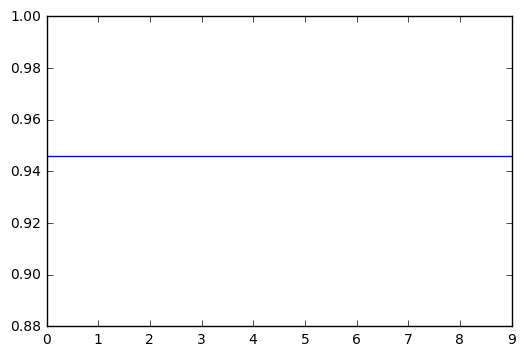

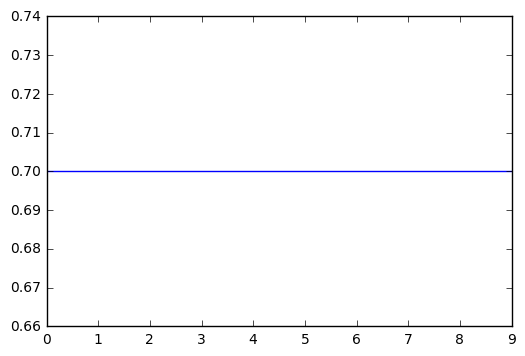

In [60]:
%matplotlib inline

from matplotlib import pyplot as plt

precList = list()
recallList = list()
for result in resultHistory:
    precList.append(result['precision']['location'])
    recallList.append(result['recall']['location'])
plt.plot(precList)
plt.show()
plt.plot(recallList)
plt.show()

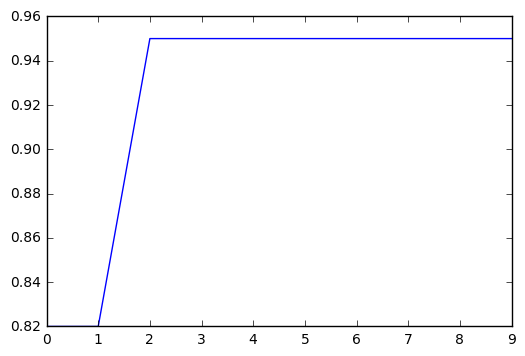

In [41]:
%matplotlib inline

from matplotlib import pyplot as plt

precList = list()
for result in resultHistory:
    precList.append(result['recall']['point'])
plt.plot(precList)
plt.show()

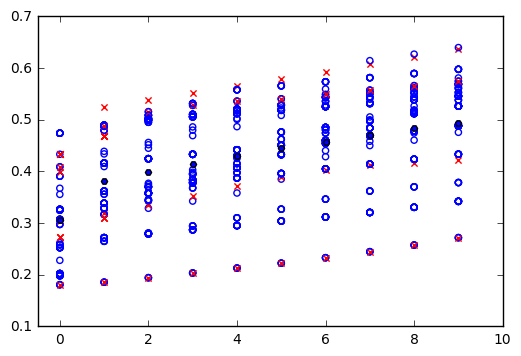

In [42]:
from matplotlib.markers import MarkerStyle
tagsetType = 'point'

scoreAvgList = list()

fig, ax = plt.subplots()
for t, result in enumerate(resultHistory):
    sampleDict = result['sampleDict']
    scoreSum = 0
    cnt = 0
    for idx, comb in sampleDict.items():
        score = comb.get_score()
        candSet = comb.get_cand_set()
        foundTagset = candSet[tagsetType]
        srcid = sensorDF.iloc[idx].name
        brickTagset = str_conv(trueDF.loc[srcid]['BRICK_POINT']).split(',')[0]
        if brickTagset!='':
            x = [t]
            y = [score]
            if check_correct(foundTagset, brickTagset):
                ax.scatter(x, y, marker='o',facecolors='none', edgecolors='b')
            else:
                ax.scatter(x, y, marker='x', facecolors='r',edgecolors='r')
            #marker.set_fillstyle('none')
            
            #ax.scatter(x,y,marker=marker)
            scoreSum += score
            cnt += 1
    avgScore = scoreSum/float(cnt)
    ax.scatter([t],[avgScore], marker='H')
ax.set_xlim(-0.5)

filename = 'figs/'+buildingName+'_scoreHistory.pdf'
save_fig(fig, filename, dpi=400)
        
#plt.show()

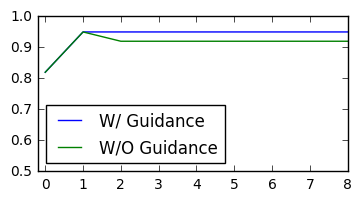

In [65]:
#if buildingName=='ap_m':
if buildingName=='ap_m':
    withGuideList = [0.9468085106,
    0.9574468085,
    0.9680851064,
    0.9680851064,
    0.9680851064,
    0.9574468085,
    0.9574468085,
    0.9574468085,
    0.9680851064]
    withoutGuideList = [0.9468085106,
    0.9574468085,
    0.9574468085,
    0.9574468085,
    0.9574468085,
    0.9574468085,
    0.9574468085,
    0.9680851064,
    0.9680851064]
elif buildingName=='ebu3b':
    withGuideList = [0.82, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
    withoutGuideList = [
    0.82,
    0.95,
    0.92,
    0.92,
    0.92,
    0.92,
    0.92,
    0.92,
    0.92]
else:
    print "No data"
    assert(False)

fig,ax = plt.subplots()
ax.plot(withGuideList, label='W/ Guidance')
ax.plot(withoutGuideList, label='W/O Guidance')
ax.legend(loc='best')
ax.set_ylim(0.5,1)
ax.set_xlim(-0.2)
fig.set_size_inches(4,2)
filename = 'figs/'+buildingName+'_prec_history.pdf'
save_fig(fig, filename, dpi=400)

In [45]:
filename = 'result/'+buildingName+'_comb_cand.csv'
with open(filename, 'wb') as fp:
    writer = csv.writer(fp)
    writer.writerow(['sentence', 'true point type', 'true equip type', 'point correct?', 'candidate combi', 'score', 'candidate combi', 'score'])
    addFunc = lambda x,y:x+y

    candScoreGetter = lambda x:(x.get_cand_set(), x.get_score())
    
    for i, combList in combListDict.items():
        #candTupleList = reduce(addFunc,map(itemgetter(1), tagsetTypeBasedList),[])
        #candTupleList = sorted(candTupleList, key=itemgetter(1), reverse=True)
        candTupleList = map(candScoreGetter, combList)
        candTupleList = sorted(candTupleList, key=itemgetter(1), reverse=True)
        comb = combList[0]
        if not buildingName in notUcsdBuildings:
            srcid = sensorDF.index[i]
            trueRow = trueDF.loc[srcid]
            pointCorrect = check_correct(bestCandScoreDict[i][1]['point'], str_conv(trueRow['Schema Label']))
            writeList = [comb.get_sentence(), trueRow['Schema Label'], trueRow['Equipment Type'], 1 if pointCorrect else 0]
        else:
            label = df.iloc[i]['Schema Label']
            writeList = [comb.get_sentence(), label]
        for candTuple in candTupleList:
            writeList.append(candTuple[0])
            writeList.append(candTuple[1])
        writer.writerow(writeList)
f = gdrive.CreateFile()
f.SetContentFile(filename)
f.Upload()
f = None

In [46]:
filename = 'result/'+buildingName+'_random_sample_result.csv'
with open(filename, 'wb') as fp:
    writer = csv.writer(fp)
    writer.writerow(['srcid', 'sentence', 'BRICK_POINT', 'estimated_point', 'point correct?', \
                     'BRICK_EQUIP', 'estimated_equip', 'equip correct?', \
                     'BRICK_LOCATION', 'estimated_loc', 'loc correct?', 'cand_set'])
    for i, combList in combListDict.items():
        rowStr = list()
        if i in randIdxList:
            srcid = sensorDF.iloc[i].name
            rowStr.append(srcid)
            (bestComb, bestCandSet, bestScore) = bestCandScoreDict[i]
            rowStr.append(bestComb.get_sentence())
            brickTagsetDict = OrderedDict()
            brickTagsetDict['point'] = str_conv(trueDF.loc[srcid]['BRICK_POINT']).split(',')
            brickTagsetDict['equip'] = str_conv(trueDF.loc[srcid]['BRICK_EQUIP_LIST']).split(',')
            brickTagsetDict['location'] = str_conv(trueDF.loc[srcid]['BRICK_LOCATION_LIST']).split(',')
            for tagsetType, correctTagsetList in brickTagsetDict.items():
                rowStr.append(correctTagsetList)
                if tagsetType in bestCandSet.keys():
                    estimatedTagset = bestCandSet[tagsetType]
                    correct = 1 if estimatedTagset in correctTagsetList else 0
                    rowStr.append(estimatedTagset)
                else:
                    correct = 0
                    rowStr.append('')
                rowStr.append(correct)
            rowStr.append(bestCandSet)
            writer.writerow(rowStr)
            
                
f = gdrive.CreateFile()
f.SetContentFile(filename)
f.Upload()
f = None

In [47]:
### Transfer knowledge

foundWordDict = OrderedDict()
cnt = 0
for (comb, candSet, candSetScore) in sorted(bestCandScoreDict.values(), key=itemgetter(2), reverse=True):
    if cnt>coverageNum*0.2:
        break
    cnt +=1
    sentence = comb.get_sentence()
    for word in sentence:
        meaningTagsetList = scoreDictDict[word].keys()
        if len(meaningTagsetList)>1:
            continue
        meaningTagset = meaningTagsetList[0]
        correctFlag = True
        for meaningTag in meaningTagset.split():
            pointTagset = candSet['point'].split('_')
            if 'equip' in candSet.keys():
                equipTagset = candSet['equip'].split('_')
            else:
                equipTagset = []
            if meaningTag not in pointTagset+equipTagset:
                correctFlag = False
        if correctFlag:
            foundWordDict[word] = meaningTagset

In [48]:
print "Finished!!!"
from IPython.display import Audio
sound_file = 'etc/fins_success.wav'
Audio(url=sound_file, autoplay=True)

Finished!!!


In [49]:
combList = origCombListDict[143]
for comb in combList:
    print comb.get_cand_set()

{'point': u'supply_fan_air_flow_sensor'}
{'point': u'fan_air_flow_sensor'}
{'point': u'discharge_fan_air_flow_sensor'}
{'point': u'return_fan_air_flow_sensor'}
{'point': u'booster_fan_air_flow_sensor'}
{'equip': u'supply_fan', 'point': u'fan_air_flow_sensor'}
{'equip': u'supply_fan', 'location': u'building', 'point': u'fan_air_flow_sensor'}
{'equip': u'supply_fan', 'location': u'city', 'point': u'fan_air_flow_sensor'}
{'equip': u'supply_fan', 'location': u'hvac_zone', 'point': u'fan_air_flow_sensor'}
{'location': u'building', 'point': u'supply_fan_air_flow_sensor'}
{'location': u'building', 'point': u'fan_air_flow_sensor'}
{'location': u'building', 'point': u'discharge_fan_air_flow_sensor'}
{'location': u'building', 'point': u'return_fan_air_flow_sensor'}
{'location': u'building', 'point': u'booster_fan_air_flow_sensor'}
{'location': u'city', 'point': u'supply_fan_air_flow_sensor'}
{'location': u'city', 'point': u'fan_air_flow_sensor'}
{'location': u'city', 'point': u'discharge_fan_air

In [50]:
print '['
for i in range(0,10):
    print int(random.random() * 2334), ','
    
print ']'

[
684 ,
2327 ,
35 ,
1172 ,
1654 ,
841 ,
836 ,
2047 ,
2136 ,
84 ,
]


In [51]:
# Evaluation!!!!!!!!!!!

# Evaluate scoring
sentenceIdxList = [
1609 ,
1317 ,
418 ,
321 ,
305 ,
283 ,
2274 ,
558 ,
813 ,
1289 ,
]
wordList = list()
for idx in sentenceIdxList:
    #print idx
    sentence = origSentenceDict[idx]
    wordList += sentence
wordList = list(set(wordList))
print wordList
if buildingName == 'ebu3b':
    evalWordMeaningDict = {'penthouse':'',
                           'code':'',
                           'feedback':'',
                           'ah':'ahu',
                           'setpoint': 'setpoint',
                           'supflow': 'supply flow',
                           'meter': 'meter',
                           'vma': '',
                           'actclg': 'effective cooling',
                           'cmd': 'command',
                           'bonner':'',
                           'n': '',
                           'occupied': 'occupied',
                           'sav':'vav',
                           'temperature':'temperature',
                           'nae':'',
                           'occ':'occupied',
                           'clg':'cooling',
                           'nd':'',
                           'efs':'exhaust fan',  ####TODO Check
                           'rd':'',
                           'th':'',
                           'rm':'room',
                           'bypdmp':'bypass damper',
                           'coomand':'command',
                           'common':'',
                           'ef':'exhaust fan',
                           'bypass':'bypass',
                           'fc':'',
                           'stpt':'setpoint',
                           'dx':'',
                           'demand':'',
                           'dmd':'',
                           'fec':'',
                           'a':'',
                           'c':'',
                           'actual':'',
                           'flr':'floor',
                           'unlock':'',
                           'roof':'',
                           't':'',
                           'st':'setpoint',
                           'sa':'supply air',
                           'com':'',
                           'vnd':'',
                           'stby':'standby',
                           'ebu':'',
                           'on':'',
                           'adj':'adjust',
                           'dmpr':'damper',
                           'pos':'position',
                           'acthtgsp':'effective heating temperature setpoint',
                           'actclgsp':'effective cooling temperature setpoint',
                           'sup':'supply',
                           'commonsp': 'setpoint',
                           'dpr':'damper',
                           
    }
elif buildingName=='bonner':
    evalWordMeaningDict = {'penthouse':'', 
                            'code':'', 
                            'feedback':'', 
                            'ah':'ahu', 
                            'supflow':'supply air flow',
                            'vma':'', 
                            'actclg':'effective cooling',
                            'cmd':'command', 
                            'bonner':'', 
                            'n':'', 
                            'sav':'vav', 
                            'nae':'',
                            'occ':'occupied', 
                            'clg':'cooling', 
                            'nd':'', 
                            'efs':'exhaust fan status', 
                            'rd':'', 
                            'th':'', 
                            'rm':'room', 
                            'bypdmp':'bypass damper', 
                            'coomand':'command',
                           'common':'',
                           'ef':'exhaust fan',
                           'bypass':'bypass',
                           'fc':'',
                           'stpt':'setpoint',
                           'dx':'',
                           'demand':'',
                           'dmd':'',
                           'fec':'',
                           'a':'',
                           'c':'',
                           'actual':'',
                           'flr':'floor',
                            'percent':'percent', 
                            'actual':'', 
                            'flr':'floor', 
                           'unlock':'',
                           'roof':'',
                           't':'', 
                           'st':'setpoint', 
                           'sa':'supply air', 
                           'com':'command'}
elif 'ap_m':
    evalWordMeaningDict = {'htg':'hetaing',
                           'int':'integral', 
                           'it':'integral', 
                           'vp':'', 
                           'ap':'',
                           'minimum':'min', 
                           'aclg':'effective cooling',
                           'ahtg':'effective heating', 
                           'sathtg': 'supply air heating', 
                           'parameters':'', 
                           'nae':'', 
                           'occ':'occupied', 
                           'rm':'room', 
                           'wc':'warm cool', 
                           'tuning':'', 'stpt':'setpoint', 'trunk':'', 'vlv':'valve', 'a':'', 'actual':'effective', 
                           'ohmin':'occupied heating min', 
                           'adj':'adjust', 'cmd':'command', 'm':'', 'n':'', 'omin':'occupied min', 
                           's':'', 'time':'', 'sa':'supply air', 'adjustment':'adjust'
                          }
    
for word in wordList:
    if word in tagList:
        evalWordMeaningDict[word] = word
    
evalScoreDictDict = dict()
for word, meaning in evalWordMeaningDict.items():
    evalScoreDictDict[word] = {meaning:1}
evalMaxScoreDict = calc_max_score_dict(evalScoreDictDict)

evalCombListDict = dict()
for idx in sentenceIdxList:
    sentence = origSentenceDict[idx]
    combList = init_comb((sentence, subTagListDictList, \
                          evalScoreDictDict, 0))
    evalCombListDict[idx] = combList
    

for i in range(0,10):
    evalCombListDict = eval_weight((evalCombListDict, evalScoreDictDict))

KeyError: 1609

In [ ]:
scoreGetter = lambda x:x.get_score()
for i, combList in evalCombListDict.items():
    bestComb = sorted(combList, key=scoreGetter, reverse=True)[0]
    print i, bestComb.get_sentence(), bestComb.get_cand_set()

In [ ]:
combList = evalCombListDict[2274]
for comb in sorted(combList, key=scoreGetter,reverse=True):
    print comb.get_cand_set(), comb.get_score()

In [ ]:
assert(False)
import google_drive
reload(google_drive)
from google_drive import gdrive